# Concrete GMM extension


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys,time

sys.path.insert(1, '../src/')
from aux import LogSumExp


import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

In [2]:
####################
####################
#   auxiliary fns  #
####################
####################
def concrete_gmm_flatten(ws,mus,Hs):
    """
    Flatten weights, meand, and logCholeskys into 2D array
    
    Inputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
    
    Outpus:
        xc  : (K',B) array, flattened values
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    K,D,B=mus.shape
    
    flat_mus=mus.reshape(K*D,B)
    idx=torch.tril_indices(D,D)
    flat_Hs=Hs[:,idx[0],idx[1],:]                     # recover lower triangular entries
    flat_Hs=flat_Hs.reshape(int(K*D*(1+0.5*(D-1))),B) # correct shape
    return torch.vstack((ws,flat_mus,flat_Hs))


def concrete_gmm_unflatten(xc,K,D):
    """
    Unflatten xc into weights, meand, and covariances
    
    Inputs:
        xc  : (K',B) array, flattened values
    
    Outputs:
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'= K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    B=xc.shape[-1]
    
    # recover each flattened var
    ws=xc[:K,:]
    flat_mus=xc[K:(K*D+K),:]
    flat_Hs=xc[(K*D+K):,:].reshape(K,int(D*(1+0.5*(D-1))),B)
    
    # unflatten separately
    mus=flat_mus.reshape(K,D,B)
    Hs=torch.zeros((K,D,D,B))
    idx=torch.tril_indices(D,D)
    Hs[:,idx[0],idx[1],:]=flat_Hs
    
    return ws,mus,Hs



def full_concrete_gmm_unflatten(x,N,K,D):
    """
    Unflatten x=[xd,xc] into label unnormalized logprbs, weights, means, and logCholesky factors
    
    Inputs:
        x   : (B,K'') array, flattened values
    
    Outputs:
        xd  : (N,K,B) array, label log probabilities (unnormalized)
        ws  : (K,B) array, weights
        mus : (K,D,B) array, cluster means
        Hs  : (K,D,D,B) array, cluster logCholesky matrices
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'' = NK (labels) + K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    """
    x=x.T
    B=x.shape[1]
    
    xd=x[:(N*K),:].reshape(N,K,B)
    xc=x[(N*K):,:]
    ws,mus,Hs=concrete_gmm_unflatten(xc,K,D)
    
    return xd,ws,mus,Hs


def concrete_gmm_unpack(x,N,K,D):
    """
    Unpack x=[xd,xc] into label normalized logprbs, weights, means, and covariances
    
    Inputs:
        x      : (B,K'') array, flattened values
    
    Outputs:
        xd     : (N,K,B) array, label log probabilities
        ws     : (K,B) array, weights
        mus    : (K,D,B) array, cluster means
        Sigmas : (K,D,D,B) array, cluster covariance matrices
        
    Note:
    K is the number of clusters, D is data dimension, 
    and B is the number of data points (for vectorizing)
    K'' = NK (labels) + K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)
    
    Note:
    The label probabilities tensor will be converted to a np array and gradients will be detached
    """
    xd,ws,mus,Hs=full_concrete_gmm_unflatten(x,N,K,D)
    xd=xd.detach().numpy()
    xd=xd-LogSumExp(np.moveaxis(xd,1,0))[:,None,:]
    
    Sigmas=HtoSigma(Hs)
    
    return xd,ws,mus,Sigmas




def HtoSigma(Hs):
    """
    Transform logCholesky factors into covariance matrices
    
    Inputs:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
        
    Outpus:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
    """
    
    idx=np.diag_indices(Hs.shape[1])
    Ls=torch.clone(Hs)
    Ls[:,idx[0],idx[1],:]=torch.exp(Hs[:,idx[0],idx[1],:])
    Ls=torch.moveaxis(Ls,3,1) # so matrices are stacked in last two axes for matmul
    Sigmas=torch.matmul(Ls,torch.moveaxis(Ls,2,3))
    return torch.moveaxis(Sigmas,1,3)

def SigmatoH(Sigmas):
    """
    Transform covariance matrices into logCholesky factors
    
    Inputs:
        Sigmas : (K,D,D,B) array, B observations of the K cluster covariances
        
    Outpus:
        Hs : (K,D,D,B) array, B observations of the K cluster logCholesky factors
    """
    
    idx=np.diag_indices(Sigmas.shape[1])
    Ls=torch.linalg.cholesky(torch.moveaxis(Sigmas,3,1))
    Hs=torch.clone(Ls)
    Hs[:,:,idx[0],idx[1]]=torch.log(Ls[:,:,idx[0],idx[1]])
    return torch.moveaxis(Hs,1,3)


def project_simplex_2d(v):
        """
        Helper function, assuming that all vectors are arranged in rows of v.

        :param v: NxD torch tensor; Duchi et al. algorithm is applied to each row in vectorized form
        :return: w: result of the projection
        
        NOTE: taken from https://github.com/smatmo/ProjectionOntoSimplex/blob/master/project_simplex_pytorch.py
        and modified by Gian Carlo Diluvi
        """
        with torch.no_grad():
            shape = v.shape
            if shape[1] == 1:
                w = v.clone().detach()
                w[:] = 1.
                return w

            mu = torch.sort(v, dim=1)[0]
            mu = torch.flip(mu, dims=(1,))
            cum_sum = torch.cumsum(mu, dim=1)
            j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
            rho = torch.sum(mu * j - cum_sum + 1. > 0.0, dim=1, keepdim=True) - 1
            max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
            theta = (torch.unsqueeze(max_nn, -1) - 1.) / (rho.type(max_nn.dtype) + 1)
            w = torch.clamp(v - theta, min=0.0)
            return w

## Gibbs Old Faithful

In [3]:
####################
####################
#  gibbs sampling  #
####################
####################
def gibbs_gmm(y,mu0,sigma0,w0,steps,burnin_pct,seed=0):
    """
    Run a Gibbs sampler for the labels x, weights w,
    means mu, and covariance matrices sigma of
    a Gaussian mixture model with obsevations
    yn~sum_k wk Gaussian(muk,sigmak), n=1,...,N

    Inputs:
        y          : (N,d) array, observations (N is no. of obs, d is dimension of each obs)
        mu0        : (K,d) array, initial means (K is number of clusters)
        sigma0     : (K,d,d) array, initial covariances
        w0         : (K,) array, initial weights
        steps      : int, number of steps to run the sampler from (after burn-in)
        burnin_pct : float, percentage of burn-in desired
        seed       : int, random seed

     Outputs:
         xs        : (steps,N) array, labels samples
         ws        : (steps,K) array, weights samples
         mus       : (steps,K,d) array, means samples
         sigmas    : (steps,K,d,d) array, covariance matrices samples

    Note: the total number of steps the sampler is run for is
          (T=steps+burn_in), where (burn_in=T*burnin_pct).
          The total burn-in steps is therefore
          (steps*burnin_pct/(1-burnin_pct))
    """
    np.random.seed(0+seed)
    
    # get sizes, calculate steps
    N,d=y.shape
    K=mu0.shape[0]
    burnin_steps=int(steps*burnin_pct/(1-burnin_pct))
    total_steps=burnin_steps+steps+1
    
    # init params
    xs=np.zeros((total_steps,N),dtype=int)
    xs[0,:]=np.random.randint(low=0,high=K,size=N)
    ws=np.ones((total_steps,K))/K
    ws[0,:]=w0
    mus=np.zeros((total_steps,K,d))
    mus[0,:,:]=mu0
    sigmas=np.ones((total_steps,K,d,d))
    sigmas[0,:,:,:]=sigma0
    
    for t in range(total_steps-1):
        if t<burnin_steps: print('Burn-in: '+str(t+1)+'/'+str(burnin_steps),end='\r')
        if t>=burnin_steps: print('Sampling: '+str(t+1-burnin_steps)+'/'+str(steps),end='\r')
        
        # update indices ###
        # first obtain log probabilities
        tmplprbs=np.ones((N,K))*np.log(ws[t,:])
        for k in range(K): tmplprbs[:,k]+=stats.multivariate_normal(mus[t,k,:],sigmas[t,k,:,:]).logpdf(y)
        # then sample using gumbel-max trick
        G=np.random.gumbel(size=(N,K))
        tmpx=np.argmax(tmplprbs+G,axis=1)
        xs[t+1,:]=tmpx
        
        # get cluster summaries
        x_tuple=np.zeros((N,K),dtype=int)
        x_tuple[np.arange(N),tmpx]=1
        Nks=np.sum(x_tuple,axis=0)
        
        # update weights ###
        tmpw=np.random.dirichlet(Nks+1)
        ws[t+1,:]=tmpw
        
        # update means and covariances ###
        for k in range(K):
            yk=y[tmpx==k,:] # cluster elements, avg in next line
            Nk=yk.shape[0]
            
            # update covariance
            Sk=Nk*np.cov(yk,rowvar=False) # cluster covariance
            tmpsigma=sigmas[t,k,:,:]
            if np.linalg.cond(Sk) < 1/sys.float_info.epsilon: tmpsigma = stats.invwishart(Nk-d-1,Sk).rvs() # Sk invertible
            sigmas[t+1,k,:,:]=tmpsigma
            
            # update mean
            mus[t+1,k,:]=np.random.multivariate_normal(np.mean(yk,axis=0),sigmas[t+1,k,:,:]/Nk)       
        # end for
    # end for
    burnin_steps+=1 # to account for initial draw
    return xs[burnin_steps:,...],ws[burnin_steps:,...],mus[burnin_steps:,...],sigmas[burnin_steps:,...]



####################
####################
#  data wrangling  #
####################
####################
of_dat=pd.read_table('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv')
dat=np.array(of_dat)



####################
####################
#      setup       #
####################
####################

# settings
K=2
steps=1000
burnin_pct=0.5
d=dat.shape[1]

# initial arrays
mu0=np.array([[2,50],[5,80]])
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(d)
w0=np.ones(K)/K


####################
####################
#   run sampler    #
####################
####################
xs,ws,mus,sigmas=gibbs_gmm(y=np.array(of_dat),mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct)

## Concrete src

In [4]:
"""
########################################
########################################
expConcrete distribution
########################################
########################################

taken from
https://pytorch.org/docs/stable/_modules/torch/distributions/relaxed_categorical.html#RelaxedOneHotCategorical
since it is not imported with torch.distributions
"""
from torch.distributions import constraints
from torch.distributions.categorical import Categorical
from torch.distributions.utils import clamp_probs, broadcast_all
from torch.distributions.distribution import Distribution
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.transforms import ExpTransform

class ExpRelaxedCategorical(Distribution):
    r"""
    Creates a ExpRelaxedCategorical parameterized by
    :attr:`temperature`, and either :attr:`probs` or :attr:`logits` (but not both).
    Returns the log of a point in the simplex. Based on the interface to
    :class:`OneHotCategorical`.

    Implementation based on [1].

    See also: :func:`torch.distributions.OneHotCategorical`

    Args:
        temperature (Tensor): relaxation temperature
        probs (Tensor): event probabilities
        logits (Tensor): unnormalized log probability for each event

    [1] The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables
    (Maddison et al, 2017)

    [2] Categorical Reparametrization with Gumbel-Softmax
    (Jang et al, 2017)
    """
    arg_constraints = {'probs': constraints.simplex,
                       'logits': constraints.real_vector}
    support = constraints.real_vector  # The true support is actually a submanifold of this.
    has_rsample = True

    def __init__(self, temperature, probs=None, logits=None, validate_args=None):
        self._categorical = Categorical(probs, logits)
        self.temperature = temperature
        batch_shape = self._categorical.batch_shape
        event_shape = self._categorical.param_shape[-1:]
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(ExpRelaxedCategorical, _instance)
        batch_shape = torch.Size(batch_shape)
        new.temperature = self.temperature
        new._categorical = self._categorical.expand(batch_shape)
        super(ExpRelaxedCategorical, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def _new(self, *args, **kwargs):
        return self._categorical._new(*args, **kwargs)

    @property
    def param_shape(self):
        return self._categorical.param_shape

    @property
    def logits(self):
        return self._categorical.logits

    @property
    def probs(self):
        return self._categorical.probs

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        uniforms = clamp_probs(torch.rand(shape, dtype=self.logits.dtype, device=self.logits.device))
        gumbels = -((-(uniforms.log())).log())
        scores = (self.logits + gumbels) / self.temperature
        return scores - scores.logsumexp(dim=-1, keepdim=True)

    def log_prob(self, value):
        K = self._categorical._num_events
        if self._validate_args:
            self._validate_sample(value)
        logits, value = broadcast_all(self.logits, value)
        log_scale = (torch.full_like(self.temperature, float(K)).lgamma() -
                     self.temperature.log().mul(-(K - 1)))
        score = logits - value.mul(self.temperature)
        score = (score - score.logsumexp(dim=-1, keepdim=True)).sum(-1)
        return score + log_scale
#========================================

"""
########################################
########################################
RealNVP architecture
########################################
########################################
"""
class RealNVP(nn.Module):
    """
    Real Non Volume Preserving architecture
    taken from
    https://colab.research.google.com/github/senya-ashukha/real-nvp-pytorch/blob/master/real-nvp-pytorch.ipynb#scrollTo=p5YX9_EW3_EU
    and adapted slightly
    """
    def __init__(self, nets, nett, mask, prior, gmm=False):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        self.gmm = gmm

    def forward(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def backward(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=-1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.backward(x)
        return self.prior.log_prob(z) + logp

    def sample(self, batchSize):
        size = (batchSize,) if self.gmm else (batchSize, 1)
        z = self.prior.sample(size).float()
        #logp = self.prior.log_prob(z)
        x = self.forward(z)
        return x

#========================================

In [5]:
"""
########################################
########################################
Gaussian mixture model training
########################################
########################################

taken from
https://colab.research.google.com/github/senya-ashukha/real-nvp-pytorch/blob/master/real-nvp-pytorch.ipynb#scrollTo=p5YX9_EW3_EU
and adapted slightly
"""


class GMMRef(Distribution):
    """
    Reference distribution for labels, weights, means, and covariances of a GMM.
    Uninformative relaxed ExpConcrete for the labels,
    Dirichlet for the weights,
    Gaussians for the means,
    and InverseWishart for the covariances

    Inputs:
        N    : int, number of observations from the GMM
        K    : int, mixture size
        tau0 : float, means prior precision
        temp : float, temperature of Concrete relaxation
    """
    def __init__(self, N,K,tau0=1.,temp=1.):
        self.relcat = ExpRelaxedCategorical(torch.tensor([temp]),torch.ones(K)/K)
        self.dirichlet = torch.distributions.dirichlet.Dirichlet(concentration=torch.ones(K))
        self.gauss  = torch.distributions.MultivariateNormal(torch.zeros(K), torch.eye(K)/np.sqrt(tau0))
        self.invwis = torch.distributions.wishart.Wishart(df=N/K,covariance_matrix=torch.eye(K))
        self.K = K
        self.N = N
        self.D = 2 # for now only 2D data

    def log_prob(self, value):
        relcat_lp = torch.zeros(value.shape[0])
        for n in range(self.N): relcat_lp += self.relcat.log_prob(value[...,n*self.K+torch.arange(0,self.K)])
            
        idx=np.diag_indices(self.D)
        xc=value[...,self.N*self.K:].T
        ws,mus,Hs=concrete_gmm_unflatten(xc,self.K,self.D) #(K,B),(K,D,B),(K,D,D,B), D=2 ONLY FOR NOW
        Sigmas=HtoSigma(Hs) #(K,D,D,B)
        xc_lp = torch.zeros(ws.shape[1])
        #xc_lp=self.dirichlet.log_prob(project_simplex_2d(ws.T)) # this is just 0 since ref is uniform
        for k in range(self.K):
            xc_lp += self.invwis.log_prob(torch.moveaxis(Sigmas[k,...],2,0))
            xc_lp += self.D*torch.log(torch.tensor([2])) + torch.sum((self.D-torch.arange(self.D)+1)[:,None]*Hs[k,idx[0],idx[1],:],axis=0) # determinant Jacobian of log-Cholesky decomposition
            xc_lp += self.gauss.log_prob(mus[k,...].T)
        # end for
        return relcat_lp+xc_lp

    def sample(self,sample_shape=torch.Size()):
        relcat_sample=self.relcat.sample(sample_shape)
        for n in range(self.N-1): relcat_sample = torch.hstack((relcat_sample,self.relcat.sample(sample_shape)))
        
        ws_sample = self.dirichlet.sample(sample_shape).T
        sigmas_sample = torch.zeros((self.K,self.D,self.D,sample_shape[0]))
        mus_sample = torch.zeros((self.K,self.D,sample_shape[0]))
        for k in range(self.K-1):
            sigmas_sample[k,...] = torch.moveaxis(self.invwis.sample(sample_shape),0,2)
            mus_sample[k,...] = self.gauss.sample(sample_shape).T
        # end for
        xc_sample = concrete_gmm_flatten(ws_sample,mus_sample,sigmas_sample).T
        return torch.hstack((relcat_sample,xc_sample))
#========================================

In [6]:
def gmm_concrete_sample(pred_x,pred_w,pred_mus,pred_sigmas,temp):
    """
    Generate sample for learning GMM with RealNVP
    using a Concrete relaxation for the labels

    Inputs:
        pred_x      : (steps,N) array, predicted label values (from `gibbs.gibbs_gmm`)
        pred_w      : (steps,K) array, predicted weights (from `gibbs.gibbs_gmm`)
        pred_mus    : (steps,K,D) array, predicted means (from `gibbs.gibbs_gmm`)
        pred_sigmas : (steps,K,D,D) array, predicted covariance matrices (from `gibbs.gibbs_gmm`)
        temp        : float, temperature of Concrete relaxation

    Outputs:
        conc_sample : (steps,K') array, samples to be used in training
        
    Note: K' = NK (labels) + K (weights) + KD (means) + Kx(D+DChoose2) (covariances, log-Cholesky decomposed)
    """
    # estimate probabilities of each xn
    pred_x=pred_x.T
    x_prbs=torch.sum(pred_x==torch.arange(0,pred_mus.shape[1],dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
    x_prbs=(x_prbs/torch.sum(x_prbs,axis=0)[None,:]).T

    # generate sample for training using Gibbs output and Gumbel soft-max
    G=torch.from_numpy(np.random.gumbel(size=(pred_x.shape[-1],x_prbs.shape[0],x_prbs.shape[1])))
    conc_sample=(x_prbs[np.newaxis,...]+G)/temp-torch.log(torch.sum(torch.exp((x_prbs[None,...]+G)/temp),axis=-1))[...,None]
    conc_sample=conc_sample.reshape(pred_x.shape[-1],x_prbs.shape[0]*x_prbs.shape[1])
    
    # deal with continuous variables
    Hs=SigmatoH(torch.moveaxis(pred_sigmas,0,3))
    xc=concrete_gmm_flatten(pred_w.T,torch.moveaxis(pred_mus,0,2),Hs).T
    
    # merge everything
    conc_sample=torch.hstack((conc_sample,xc)).float()

    return conc_sample

In [7]:
def createGMMRealNVP(temp,depth,N,K,tau0,width=32):
    """
    Wrapper to init a RealNVP class for a GMM problem

    The reference distribution is a relaxed uniform in exp space
    for the labels and a multivariate normal with precision tau0
    for the means

    Inputs:
        temp   : float, temperature of Concrete relaxation
        depth  : int, number of couplings (transformations)
        N      : int, number of observations from the GMM
        K      : int, mixture size
        tau0   : float, prior precision for means
        width : int, width of the linear layers

    Outputs:
        flow   : Module, RealNVP
    """
    D=2 # currently only 2D examples supported
    dim=int(K*N+K+K*D+K*(D+D*(D-1)/2))

    # create channel-wise masks of appropriate size
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)

    # define reference distribution
    ref = GMMRef(N,K,tau0,temp)

    # define scale and translation architectures
    net_s = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim),
        nn.Tanh()
    )
    net_t = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim)
    )
    return RealNVP(net_s, net_t, masks, ref, gmm=True)

In [8]:
def trainGMMRealNVP(temp,depth,N,K,tau0,sample,width=32,max_iters=1000,lr=1e-4,seed=0,verbose=True):
    """
    Train a RealNVP normalizing flow targeting lprbs using the Adam optimizer

    Input:
        temp      : float, temperature of Concrete relaxation
        depth     : int, number of couplings (transformations)
        N         : int, number of observations from the GMM
        K         : int, mixture size
        tau0      : float, prior precision for means
        sample    : (B,K*(N+1)) array, samples from target for training; B is the Monte Carlo sample size
        width     : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        seed      : int, for reproducinility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam
    """
    torch.manual_seed(seed)

    # create flow
    flow=createGMMRealNVP(temp,depth,N,K,tau0,width)

    # train flow
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)

    for t in range(max_iters):
        loss = -flow.log_prob(sample).mean()
        losses[t]=loss

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

## Training

In [62]:
# settings
temp=0.5
depth=15
width=16
max_iters=1000
lr=5*1e-5 # on this scale, never larger than 1e-4
N=dat.shape[0]
K=2
tau0=1.

# convert gibbs output to torch tensors
xs_concrete = torch.from_numpy(xs)
ws_concrete = torch.from_numpy(ws)
mus_concrete = torch.from_numpy(mus)
sigmas_concrete = torch.from_numpy(sigmas)

In [63]:
# create Concrete sample
conc_sample=gmm_concrete_sample(xs_concrete,ws_concrete,mus_concrete,sigmas_concrete,temp)

In [64]:
tmp_flow,tmp_loss=trainGMMRealNVP(
    temp=temp,depth=depth,N=N,K=K,tau0=tau0,sample=conc_sample,width=width,max_iters=max_iters,lr=lr,seed=2023,verbose=True
)

iter 0: loss = 10236607856640.000
iter 100: loss = 41589.461
iter 200: loss = 41017.637
iter 300: loss = 40454.008
iter 400: loss = 39888.762
iter 500: loss = 39328.453
iter 600: loss = 38775.000
iter 700: loss = 38227.637
iter 800: loss = 37685.383
iter 900: loss = 37149.379


In [65]:
txd,tws,tmus,tSigmas=concrete_gmm_unpack(tmp_flow.sample(1000),N,K,2)

In [66]:
tws,tmus,tSigmas=tws.detach().numpy(),tmus.detach().numpy(),tSigmas.detach().numpy()

In [67]:
tSigmas[np.isinf(tSigmas)]=np.nan
pltSigmas=np.nanmean(tSigmas,axis=-1)
pltSigmas[np.isinf(pltSigmas)]=1e5
print(pltSigmas)

[[[ 1.4897506e+29 -3.0297667e+36]
  [-3.0297667e+36  1.0000000e+05]]

 [[ 6.0384786e-01 -2.4453757e-02]
  [-2.4453757e-02  2.9010958e+06]]]


Text(0, 0.5, 'Wait time')

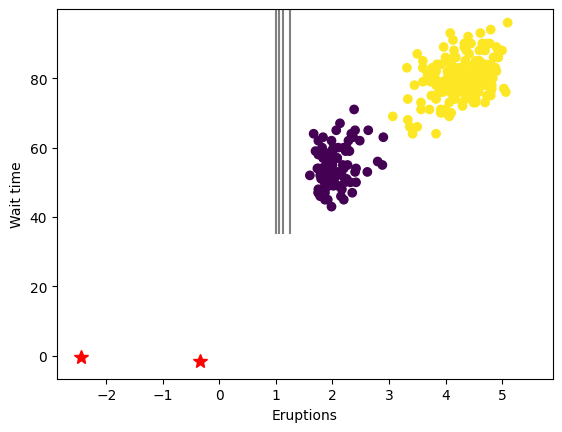

In [69]:
####################
####################
#     results      #
####################
####################
plt.scatter(dat[:,0],dat[:,1],c=xs[-1,:])
plt.plot(np.mean(tmus,axis=-1)[:,0],np.mean(tmus,axis=-1)[:,1],'*r',ms=10)

xx, yy = np.mgrid[1:6:.1, 35:100:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(np.mean(tmus,axis=-1)[k,:], pltSigmas[k,:,:])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')

    
plt.xlabel('Eruptions')
plt.ylabel('Wait time')